In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import numpy as np

In [4]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

import NaiveDE
import SpatialDE

In [5]:
sc.set_figure_params(facecolor='white', figsize=(8, 8))
sc.settings.verbosity = 3

In [8]:
cell_by_gene = pd.read_csv('/data/home/jiaying/MERFISH/data/vizgen/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_by_gene_S2R1.csv', index_col=0)
cells = cell_by_gene.index.tolist()
meta_cell = pd.read_csv('/data/home/jiaying/MERFISH/data/vizgen/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_metadata_S2R1.csv', index_col=0)
meta_cell['barcodeCount'] = cell_by_gene.sum(axis=1)
meta_cell = meta_cell.loc[cells]
meta_cell.index = range(len(meta_cell.index.tolist()))

# initialize meta_gene
meta_gene = pd.DataFrame(index=cell_by_gene.columns.tolist())

# drop blanks for single cell analysis
keep_genes = [x for x in cell_by_gene.columns.tolist() if 'Blank' not in x]

cell_by_gene = cell_by_gene[keep_genes]
meta_gene = meta_gene.loc[keep_genes]

meta_gene['expression'] = cell_by_gene.sum(axis=0)


In [9]:
counts = cell_by_gene
counts.T[counts.sum(0) >= 3].T
print(counts.shape)
counts.iloc[:5, :5]

(83546, 483)


,Oxgr1,Htr1a,Htr1b,Htr1d,Htr1f
149164679103246548309819743981609972453,1.0,0.0,0.0,0.0,0.0
215843146921706462965382248182021894607,0.0,0.0,1.0,0.0,0.0
230248905804673613678286091156141465134,0.0,0.0,0.0,0.0,0.0
237155298815097057940587033798543926454,0.0,0.0,0.0,0.0,0.0
256099454901769634241742157204636917386,0.0,0.0,0.0,0.0,0.0


In [10]:
sample_info = pd.read_csv('/data/home/jiaying/MERFISH/data/vizgen/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_metadata_S2R1.csv', index_col=0)
counts = counts.loc[sample_info.index]

In [11]:
sample_info['total_count'] = cell_by_gene.sum(axis=1)
sample_info

,fov,volume,center_x,center_y,min_x,max_x,min_y,max_y,total_count
149164679103246548309819743981609972453,22,702.985117,638.564040,4594.216444,633.050640,644.077440,4588.373644,4600.059245,112.0
215843146921706462965382248182021894607,22,1601.521287,593.803439,4516.240442,584.666639,602.940239,4504.889642,4527.591243,81.0
230248905804673613678286091156141465134,22,999.080438,597.313439,4566.676444,589.202639,605.424239,4557.485643,4575.867244,72.0
237155298815097057940587033798543926454,22,1343.252320,613.243439,4609.498445,606.482639,620.004239,4600.469645,4618.527245,127.0
256099454901769634241742157204636917386,22,791.421453,609.193439,4603.180445,602.594639,615.792239,4596.041644,4610.319245,59.0
...,...,...,...,...,...,...,...,...,...
228664397583799424769953471170828485497,1362,1287.925067,9358.279627,4260.179008,9347.684827,9368.874427,4250.718208,4269.639809,63.0
23913614753721247824828284819434942698,1362,1077.598116,9334.573626,4392.101012,9326.408826,9342.738427,4381.722211,4402.479812,60.0
265242905022798846132446878658891240171,1362,724.988088,9342.349627,4285.073009,9336.344826,9348.354427,4278.366209,4291.779809,57.0
323169293857992050739513584513532925918,1362,1926.005095,9350.503627,4398.743012,9339.584826,9361.422427,4388.202212,4409.283812,110.0


In [12]:
norm_expr = NaiveDE.stabilize(counts.T).T
resid_expr = NaiveDE.regress_out(sample_info, norm_expr.T, 'np.log(total_count)').T

In [13]:
resid_expr

,Oxgr1,Htr1a,Htr1b,Htr1d,Htr1f,Htr2a,Htr2b,Htr2c,Htr4,Htr5a,...,Pdgfrb,Ptk7,Ret,Ror1,Ror2,Ros1,Ryk,Tek,Tie1,Tyro3
149164679103246548309819743981609972453,-0.156692,-3.270335,-3.622680,-2.318133,-4.050141,-3.748930,-1.982271,-3.518570,-3.495808,-4.874896,...,-1.857308,-3.985977,-3.274178,-2.289633,-2.116496,-2.010802,-3.863038,-1.541954,-1.751427,-6.608830
215843146921706462965382248182021894607,-2.216686,-3.179416,-1.427642,-2.292608,-3.905668,-3.625142,-1.979812,-3.410603,-3.389404,-4.673782,...,-1.863431,-3.845910,-3.182995,-2.266065,-2.104819,-2.006384,-5.668494,-1.569734,-1.764821,-6.288635
230248905804673613678286091156141465134,-2.209444,-3.146369,-3.465721,-2.283330,-3.853156,-3.580149,-1.978918,-3.371360,-3.350729,-4.600682,...,-1.865656,-3.795000,-3.149853,-2.257499,-2.100574,-2.004777,-2.860171,0.500091,-1.769689,-6.172253
237155298815097057940587033798543926454,-2.244342,-3.305599,-3.667330,-2.328034,-4.106178,-3.796943,-1.983225,-3.560447,-3.537078,-4.952902,...,-1.854933,-4.040305,-1.229624,-2.298774,-2.121025,-2.012516,-6.049416,-1.531179,-1.746231,-6.733024
256099454901769634241742157204636917386,-2.197199,-3.090499,-3.394982,-2.267645,-3.764377,-3.504082,-1.977406,-3.305015,-3.285344,-4.477097,...,-1.869418,-3.708929,-3.093821,-2.243016,-2.093398,-2.002062,-3.320153,-1.596902,-1.777920,-5.975493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228664397583799424769953471170828485497,-2.201232,-3.108904,-3.418285,-2.272812,-3.793623,-3.529140,-1.977904,-3.326870,-3.306883,-4.517809,...,-1.868179,-3.737283,-3.112279,-2.247787,-2.095762,-2.002956,-3.375713,-1.591278,-1.775208,-6.040310
23913614753721247824828284819434942698,-2.198232,-3.095215,-3.400953,-2.268969,-3.771870,-3.510502,-1.977534,-3.310614,-3.290863,-4.487528,...,-1.869101,-3.716194,-3.098550,-2.244239,-0.014082,-2.002291,-2.322744,-1.595461,1.590600,-5.992101
265242905022798846132446878658891240171,-2.195078,-3.080823,-3.382731,-2.264928,-3.749002,-3.490908,-1.977145,-3.293524,-3.274020,-4.455694,...,0.209852,-3.694023,-3.084117,-2.240508,-2.092155,-2.001592,-3.290943,-1.599858,-1.779345,-5.941417
323169293857992050739513584513532925918,-2.235505,-3.265279,-3.616279,-2.316714,-4.042108,-3.742047,-1.982134,-3.512567,-3.489891,-4.863714,...,1.904087,-1.898267,-3.269108,-0.208401,-2.115847,-2.010557,-3.847776,-1.543498,0.327750,-6.591026


In [14]:
test = resid_expr.head(800)

In [15]:
test_info = sample_info.head(800)

In [16]:
X = test_info[['center_x', 'center_y']]
results = SpatialDE.run(X, test)

/data/home/jiaying/software/miniconda3/envs/allcools/lib/python3.8/site-packages/SpatialDE/base.py:26: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])
/data/home/jiaying/software/miniconda3/envs/allcools/lib/python3.8/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

In [17]:
results.head().T

,0,1,2,3,4
FSV,0.999955,0.999955,0.999955,0.999955,0.999955
M,4,4,4,4,4
g,Cnr2,Cysltr2,Casr,Fshr,Fzd4
l,1.014568,1.014568,1.014568,1.014568,1.014568
max_delta,0.000045,0.000045,0.000045,0.000045,0.000045
max_ll,79.889232,-469.659078,-254.881304,-311.816223,-805.684895
max_mu_hat,-1.998366,-2.016515,-2.208062,-2.178708,-2.037631
max_s2_t_hat,4.03933,4.253638,4.983718,4.871953,4.588585
model,SE,SE,SE,SE,SE
n,800,800,800,800,800


In [18]:
results.sort_values('qval').head(10)[['g', 'l', 'qval']]

,g,l,qval
358,Chrm1,111.756558,0.0
311,ADGRF3,111.756558,0.0
313,Mc2r,111.756558,0.0
288,Drd1,43.638985,0.0
318,Ccr8,111.756558,0.0
425,Tyro3,111.756558,0.0
260,Gpr119,17.040262,0.0
319,Cxcr5,111.756558,0.0
419,Met,111.756558,0.0
385,Taar8b,111.756558,0.0


/tmp/ipykernel_53767/3853482952.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(ticks=[]);


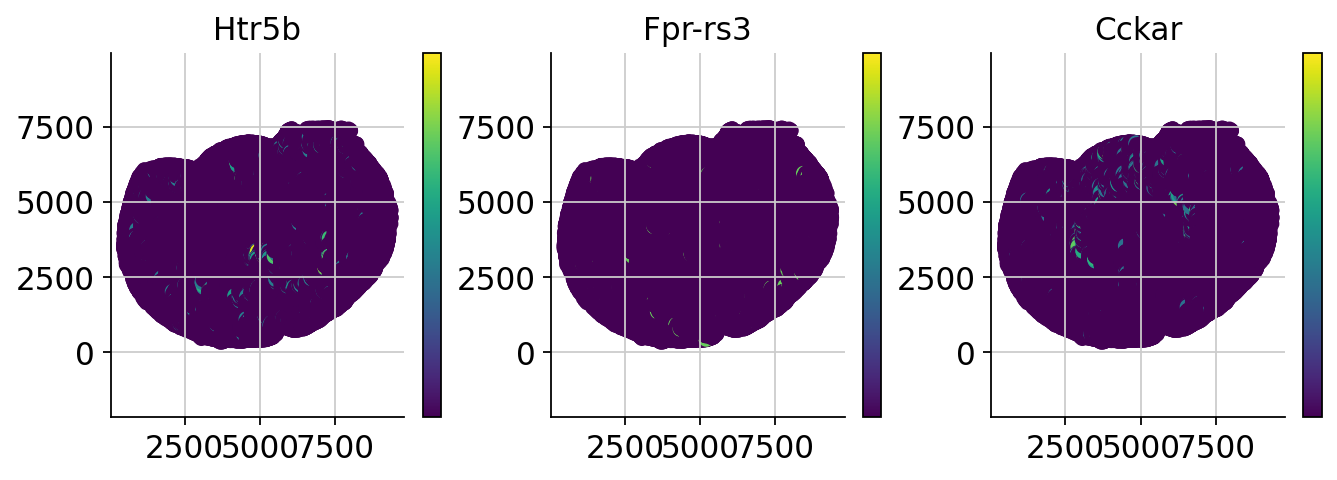

In [22]:
figsize(10, 3)
for i, g in enumerate(['Htr5b', 'Fpr-rs3', 'Cckar']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['center_x'], sample_info['center_y'], c=norm_expr[g]);
    plt.title(g)
    plt.axis('equal')


    plt.colorbar(ticks=[]);

In [23]:
results.sort_values('qval').tail(10)[['g', 'l', 'qval']]

,g,l,qval
7,Gpr55,1.014568,0.404254
4,Fzd4,1.014568,0.406089
19,Taar6,1.014568,0.409096
8,Npffr2,1.014568,0.410935
10,P2ry4,1.014568,0.426792
367,Ptafr,111.756558,0.426792
349,Mrgprb2,111.756558,0.426792
348,Lpar6,111.756558,0.426792
6,Gpr39,1.014568,0.426792
11,Gpr142,1.014568,0.426792


/tmp/ipykernel_53767/3925941706.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(ticks=[]);


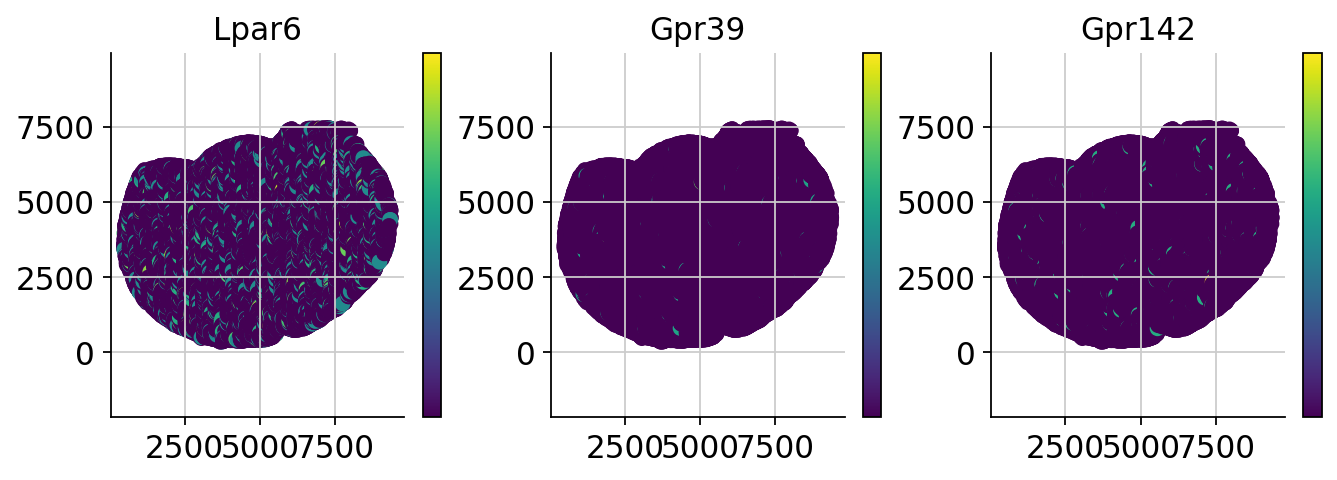

In [25]:
figsize(10, 3)
for i, g in enumerate(['Lpar6', 'Gpr39', 'Gpr142']):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['center_x'], sample_info['center_y'], c=norm_expr[g]);
    plt.title(g)
    plt.axis('equal')


    plt.colorbar(ticks=[]);

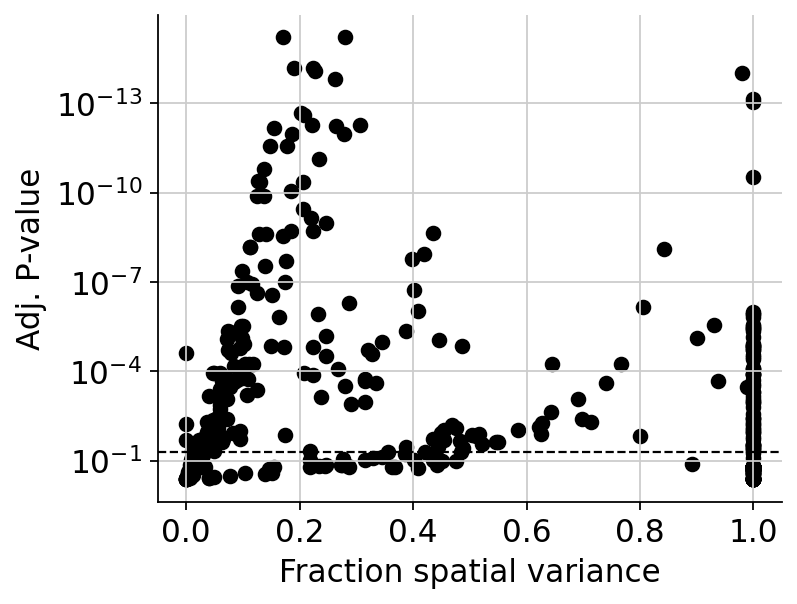

In [26]:
figsize(5, 4)
plt.yscale('log')

plt.scatter(results['FSV'], results['qval'], c='black')

plt.axhline(0.05, c='black', lw=1, ls='--');

plt.gca().invert_yaxis();
plt.xlabel('Fraction spatial variance')
plt.ylabel('Adj. P-value');

In [27]:
sign_results = results.query('qval < 0.5')

In [28]:
sign_results['l'].value_counts()

6.653925       128
111.756558     124
2.598241       103
286.201163      47
17.040262       30
1.014568        22
43.638985       19
1877.016764      6
732.942277       4
Name: l, dtype: int64

In [29]:
histology_results, patterns = SpatialDE.aeh.spatial_patterns(X, test, sign_results, C=3, l=1.8, verbosity=1)

/data/home/jiaying/software/miniconda3/envs/allcools/lib/python3.8/site-packages/SpatialDE/base.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  R2 = -2. * np.dot(X, X.T) + (Xsq[:, None] + Xsq[None, :])


iter 0, ELBO: -8.18e+03
iter 1, ELBO: -6.83e+05, delta_ELBO: 6.75e+05
iter 2, ELBO: -7.41e+05, delta_ELBO: 5.86e+04
iter 3, ELBO: -7.40e+05, delta_ELBO: 1.61e+03
iter 4, ELBO: -7.42e+05, delta_ELBO: 2.28e+03
iter 5, ELBO: -7.44e+05, delta_ELBO: 1.43e+03
iter 6, ELBO: -7.44e+05, delta_ELBO: 3.04e+02
iter 7, ELBO: -7.44e+05, delta_ELBO: 8.28e+01
iter 8, ELBO: -7.44e+05, delta_ELBO: 3.51e+01
iter 9, ELBO: -7.44e+05, delta_ELBO: 2.93e+01
iter 10, ELBO: -7.44e+05, delta_ELBO: 1.85e+01
iter 11, ELBO: -7.44e+05, delta_ELBO: 1.09e+01
iter 12, ELBO: -7.44e+05, delta_ELBO: 4.84e+00
iter 13, ELBO: -7.44e+05, delta_ELBO: 1.29e+00
iter 14, ELBO: -7.44e+05, delta_ELBO: 3.87e+00
iter 15, ELBO: -7.44e+05, delta_ELBO: 3.43e-01
iter 16, ELBO: -7.44e+05, delta_ELBO: 7.19e-01
iter 17, ELBO: -7.44e+05, delta_ELBO: 2.59e+00
iter 18, ELBO: -7.44e+05, delta_ELBO: 3.55e-02
iter 19, ELBO: -7.44e+05, delta_ELBO: 1.77e-02
iter 20, ELBO: -7.44e+05, delta_ELBO: 4.39e-03
Converged on iter 20


In [30]:
histology_results.head()

,g,pattern,membership
0,Cnr2,0,1.0
1,Cysltr2,2,1.0
2,Casr,0,1.0
3,Fshr,0,1.0
4,Fzd4,0,1.0


/tmp/ipykernel_53767/608539152.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(ticks=[]);


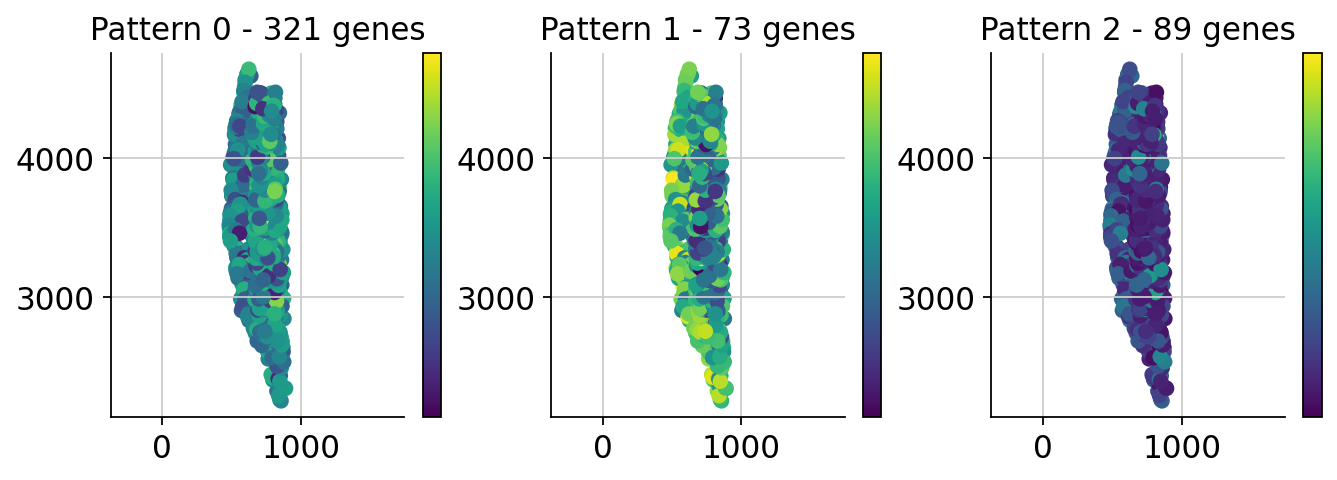

In [31]:
figsize(10, 3)
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(test_info['center_x'], test_info['center_y'], c=patterns[i]);
    plt.axis('equal')
    plt.title('Pattern {} - {} genes'.format(i, histology_results.query('pattern == @i').shape[0] ))
    plt.colorbar(ticks=[]);

In [32]:
for i in histology_results.sort_values('pattern').pattern.unique():
    print('Pattern {}'.format(i))
    print(', '.join(histology_results.query('pattern == @i').sort_values('membership')['g'].tolist()))
    print()

Pattern 0
Mc5r, Erbb3, Brs3, Gpr152, Adra2c, Glp1r, Gpr39, Pth2r, Ccr9, Ccr7, Grm6, Ghsr, Mc3r, Xcr1, Epha2, Adgra1, Adgra2, Dlk1, Ptger4, Gprc6a, Tas2r7, Hcrtr1, Tshr, Htr5b, Opn1sw, Ephb3, Prokr2, Fzd1, Ptger2, Ptger3, Vipr2, Htr1a, Mrgprb1, Gpr87, Avpr1b, Galr1, Taar6, Cxcr4, Arhgap29, Insr, Cmklr1, Taar8a, Tacr2, Gpr33, P2ry2, Cxcl12, Nmur2, V1ra8, Ghrhr, Mrgprb8, Fzd4, Mtnr1a, Drd3, Hrh1, Ptgir, Taar7f, Drd1, Ros1, Ffar1, Gpr82, Fgfr4, Gpr50, Gprc5a, Vmn1r46, Taar3, Gpr132, Ltb4r2, Ptgdr2, Gpr65, Adgrf2, Eomes, Hcar2, Gpr150, Ptk7, Taar2, Vmn1r47, Vmn1r44, Taar7e, Mrgprf, Sstr5, Ccr1, Gpr6, Gpr141, Vmn1r52, Avpr2, Gpr119, Fshr, Mrgpre, Taar7d, Npy6r, Adgrl2, Adra1d, Adgrl3, Adrb2, Adrb1, C3ar1, Cnr1, Crhr1, Adgrb3, Fzd3, Gpr183, Ephb6, Gpr22, Ackr2, Adgrb1, Chrm3, Htr2a, Cxcr3, Cxcr6, Gpr34, Gabbr1, Opn5, Taar4, Vmn2r26, Lmtk2, Nrp2, Adora1, Htr2c, Adgrf4, Adra2a, Ackr1, Ffar3, Grm1, Ephb2, F2rl2, Mas1, Epha6, Ntrk3, Htr1b, Flt3, Gpr26, Mchr1, Gabbr2, Pcdh15, Syt4, Baiap2, Gpr162,